Data Preprocessing
Import the libraries

In [1]:
!pip install ibm-cos-sdk | grep -v 'already satisfied'
import ibm_boto3
from ibm_botocore.client import Config
import pandas as pd
import numpy as np
import io, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.12.0-py3-none-any.whl size=73931 sha256=4a1d26f6bc0363c5fc229dd802d8972aa78e86986742aec04e37ab29ee8d9918
  Stored in directory: /root/.cache/pip/wheels/ec/94/29/2b57327cf00664b6614304f7958abd29d77ea0e5bbece2ea57
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.12.0-py3-none-any.whl size=562962 sha256=822e0aa37936eaaabc9f3c6716e52248236016c38043f7db56b82ceb23707a2a
  Stored in directory: /root/.cache/pip/wheels/64/56/fb/5cd6f4f40406c828a5289b95b2752a4d142a9afb359244ed8d
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.12.0-py3-none-any.whl size=89778 sha256=5f42a16af617072084a8277b99c00e1a8ba782dfe6e32e292a99f5862c8037ef
  Stored in directory: /root/.cache/pip/wheels/57/79/6a/ffe3370ed7ebc00604f9f76766e1e0348dcdcad2b2e32df9e1
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3tr

Importing the dataset

In [2]:
cos_credentials={
  "apikey": "5lDfM8QcqpTFlKVVjKmm06zGbSspFR6gqGpmbFDWLlRc",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297:resource-key:cd3a6762-cdaf-4808-b931-198e378e86d5",
  "iam_apikey_name": "pnt2022tmid13214",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/d2c796b84a794b58a1cff48368133ea1::serviceid:ServiceId-469be452-375b-4d58-9c23-d742c9a3256e",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297::"
}
auth_endpoint = 'https://iam.cloud.ibm.com/oidc/token'
service_endpoint = 'https://s3.us-east.cloud-object-storage.appdomain.cloud'
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)
obj =cos.get_object(Bucket='pnt2022tmid13214', Key='Crude Oil Prices Daily.xlsx')
df = pd.read_excel(io.BytesIO(obj['Body'].read()), header=None, names=['date', 'price'] ,skiprows=1)
df.head()

,date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


Handling missing data

In [3]:
df.isnull().any()

date     False
price     True
dtype: bool

In [4]:
df.dropna(axis=0,inplace=True)
df.isnull().any()

date     False
price    False
dtype: bool

In [5]:
df.shape

(8216, 2)

Data visualization

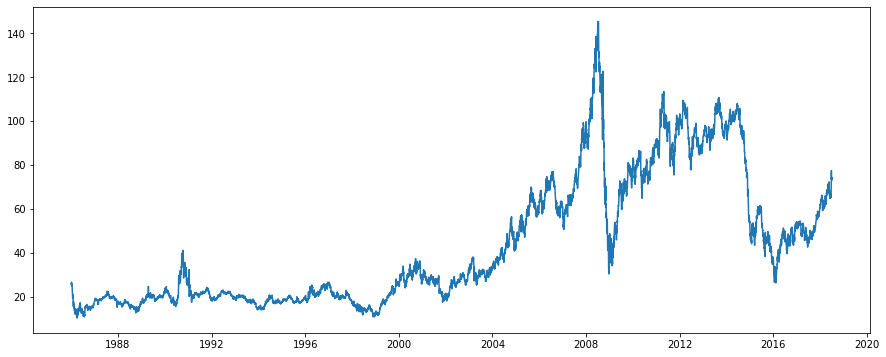

In [6]:
plot = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['date'])
price = list(df['price'])
data = pd.Series(price, time)
plt.plot(data)

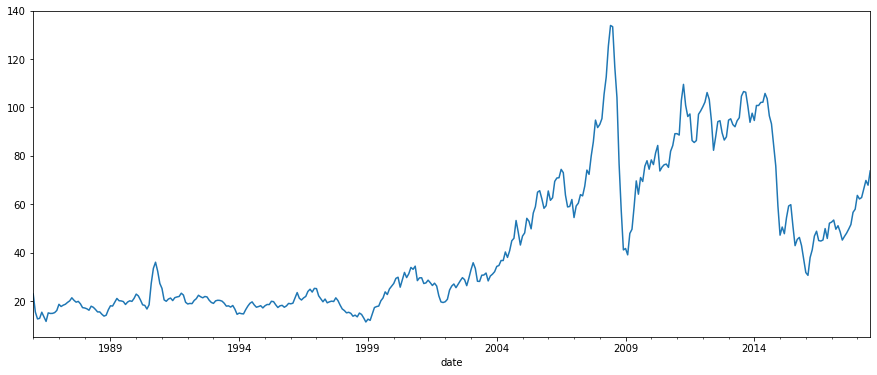

In [7]:
#Decompose the plot
df.set_index('date', inplace=True)
y = df['price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

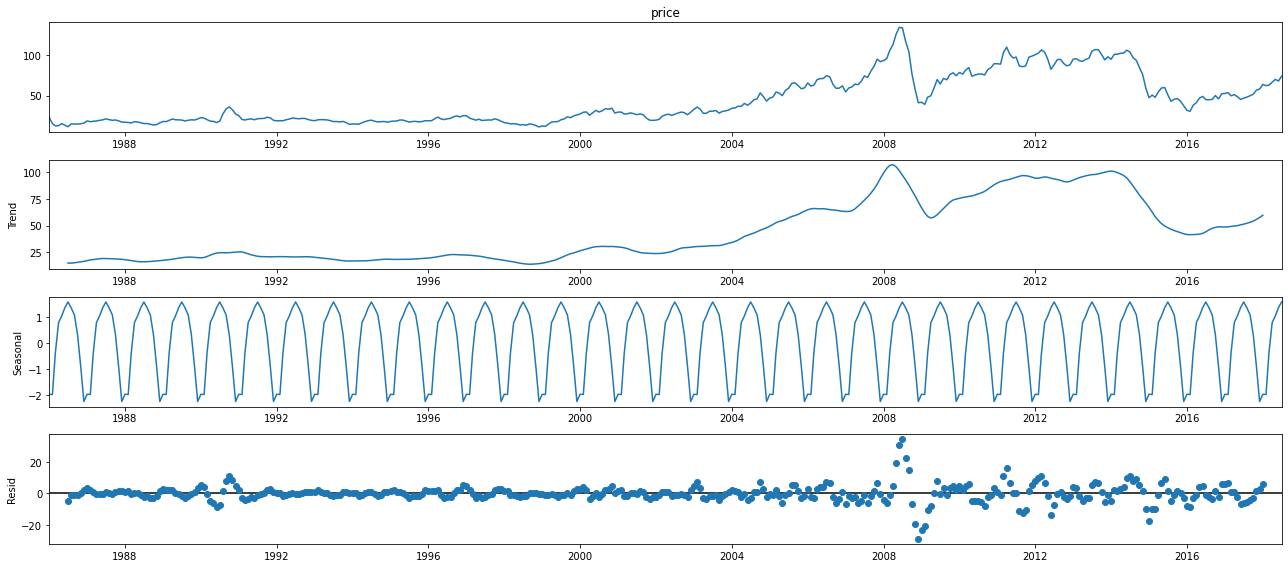

In [8]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Feature Scaling

In [9]:
df1 = df.reset_index()['price']
sc = MinMaxScaler(feature_range = (0, 1))
df1 = sc.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1.shape

(8216, 1)

Train Test Split

In [11]:
train_size = int(len(df1) * 0.80)
test_size = len(df1) - train_size
train, test = df1[0:train_size, :], df1[train_size:len(df1), :]

In [12]:
len(test)

1644

Creating Window

In [13]:
def dataset(df, lookback=1):
    data_x, data_y = [], []
    for i in range(len(df) - lookback - 1):
        a = df[i:(i + lookback), 0]
        data_x.append(a)
        data_y.append(df[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

time_step = 10
# Reshape into X=t and Y=t+1
X_train , Y_train = dataset(train,time_step)
X_test , Y_test = dataset(test,time_step)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [14]:
X_train.shape

(6561, 10, 1)

Model Building
Import the Model building libraries

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Initializing the Model
Adding LSTM Layers
Adding Output Layers

In [16]:
model = Sequential()
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(units = 10, return_sequences = True))
model.add(LSTM(units = 10))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 2,171
Trainable params: 2,171
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 1st LSTM Layer 
print(4 * 10 * (1 + 10 + 1))

480


In [18]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


Configure the Learning Process

In [19]:
history = model.fit(X_train, Y_train, epochs = 30, batch_size = 64,validation_data=(X_test, Y_test),verbose=2)

Epoch 1/30
103/103 - 9s - loss: 0.0198 - val_loss: 5.4834e-04 - 9s/epoch - 86ms/step
Epoch 2/30
103/103 - 2s - loss: 4.6403e-04 - val_loss: 5.4829e-04 - 2s/epoch - 20ms/step
Epoch 3/30
103/103 - 2s - loss: 4.4328e-04 - val_loss: 5.6335e-04 - 2s/epoch - 19ms/step
Epoch 4/30
103/103 - 2s - loss: 4.3142e-04 - val_loss: 6.9256e-04 - 2s/epoch - 20ms/step
Epoch 5/30
103/103 - 1s - loss: 4.3585e-04 - val_loss: 5.1676e-04 - 1s/epoch - 14ms/step
Epoch 6/30
103/103 - 2s - loss: 4.0726e-04 - val_loss: 5.7871e-04 - 2s/epoch - 19ms/step
Epoch 7/30
103/103 - 1s - loss: 4.0256e-04 - val_loss: 5.0603e-04 - 1s/epoch - 14ms/step
Epoch 8/30
103/103 - 2s - loss: 3.8334e-04 - val_loss: 4.5717e-04 - 2s/epoch - 15ms/step
Epoch 9/30
103/103 - 2s - loss: 3.9195e-04 - val_loss: 4.8559e-04 - 2s/epoch - 15ms/step
Epoch 10/30
103/103 - 2s - loss: 3.6645e-04 - val_loss: 5.4013e-04 - 2s/epoch - 18ms/step
Epoch 11/30
103/103 - 1s - loss: 3.8120e-04 - val_loss: 4.2582e-04 - 1s/epoch - 14ms/step
Epoch 12/30
103/103 - 1

Train the model

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

52/52 [==============================] - 0s 4ms/step


In [21]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Model evaluation

In [22]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.2735953856568354
Train Root Mean Squared Error: 2.0077166677586864
Test Mean Absolute Error: 1.7654385546972178
Test Root Mean Squared Error: 2.2663714480676


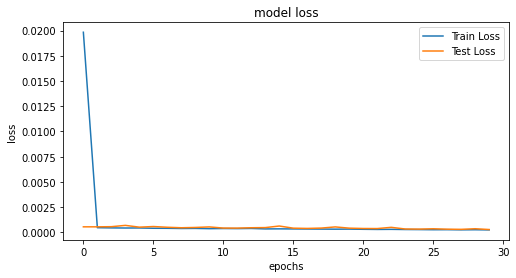

In [23]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

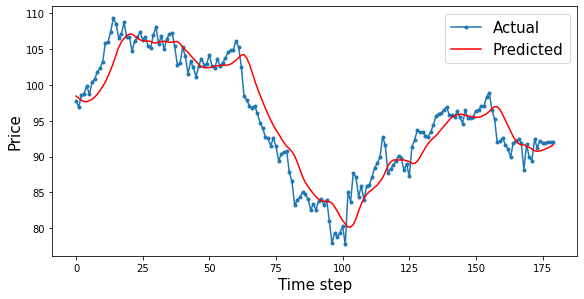

In [24]:
data = [i for i in range(180)]
plt.figure(figsize=(8,4))
plt.plot(data, Y_test[0][:180], marker='.', label="Actual")
plt.plot(data, test_predict[:,0][:180], 'r', label="Predicted")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Save the model

In [25]:
model.save("model.h5")
!tar -zcvf model.tgz model.h5

model.h5


Test the model

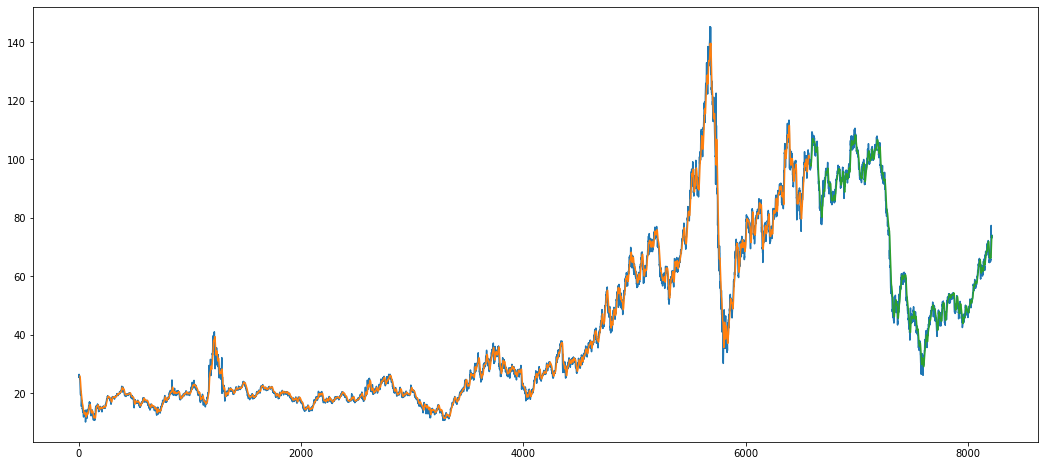

In [26]:
# Model Testing
look_back = 10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict
plt.plot(sc.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
x_input = test[len(test)-10:].reshape(1,-1)
x_input.shape

(1, 10)

In [28]:
temp_input = list(x_input[0])
temp_list = temp_input[0].tolist()

In [29]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [30]:
lst_output = []
n_steps = 10
i = 0
while(i<10):
  if(len(temp_input) > 10):
    x_input = np.array(temp_input[1:])
    print("Day {} Input {}".format(i,x_input),end="\n")
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} Output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print("------------------------",end="\n")
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1

Day 0 output [[0.4741927]]
Day 1 Input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47419271]
Day 1 Output [[0.47477219]]
------------------------
Day 2 Input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47419271 0.47477219]
Day 2 Output [[0.47443226]]
------------------------
Day 3 Input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47419271 0.47477219 0.47443226]
Day 3 Output [[0.47404733]]
------------------------
Day 4 Input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47419271 0.47477219 0.47443226 0.47404733]
Day 4 Output [[0.4747072]]
------------------------
Day 5 Input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47419271
 0.47477219 0.47443226 0.47404733 0.47470719]
Day 5 Output [[0.47519973]]
------------------------
Day 6 Input [0.47341922 0.46497853 0.47038353 0.47149415 0.47419271 0.47477219
 0.47